In [58]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import tqdm
from itertools import combinations

from implicit.nearest_neighbours import bm25_weight

from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier, LGBMRanker
from gensim.models import Word2Vec

import optuna
from optuna.samplers import TPESampler

from uitls import *
import gc
gc.enable()

In [168]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')
test = pd.read_csv('test_user.csv')

N_preds = 10

In [169]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [170]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [171]:
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=10000, n_weeks=95)

In [172]:
data_train["item_id"] = data_train["item_id"].astype("str")
data_test["item_id"] = data_test["item_id"].astype("str")

In [54]:
items_train = []

for user in tqdm.tqdm(data_train["user_id"].unique()):
    temp = data_train[data_train["user_id"] == user]["item_id"].tolist()
    items_train.append(temp)
    
items_val = []

for user in tqdm.tqdm(data_test['user_id'].unique()):
    temp = data_test[data_test["user_id"] == user]["item_id"].tolist()
    items_val.append(temp)

100%|████████████████████████████████████████████████████████████████████████████| 2042/2042 [00:00<00:00, 4520.62it/s]


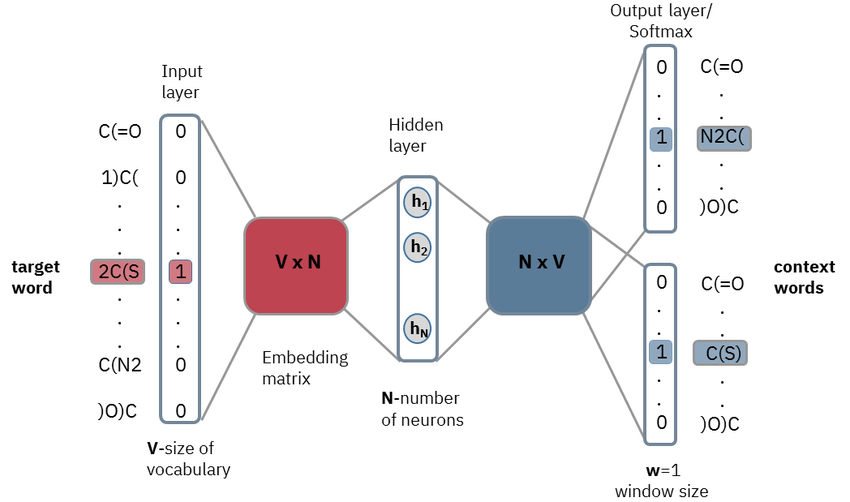

In [55]:
model = Word2Vec(window=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=42)

model.build_vocab(items_train, progress_per=200)

model.train(items_train, total_examples=model.corpus_count, epochs=20, report_delay=1)
model.init_sims(replace=True)

In [297]:
result = data_test.groupby("user_id")["item_id"].unique().reset_index()
result["preds"] = result["user_id"].apply(lambda x: get_prediction(x, 30))  # KeyError may occur
result.rename(columns={"item_id": "actual"}, inplace=True)

In [298]:
result.apply(lambda x: precision_at_k(x["preds"], x["actual"], 5), axis=1).mean()

0.11234084231145934

In [299]:
result.apply(lambda x: recall_at_k(x["preds"], x["actual"], 5), axis=1).mean()

0.015036472760443707

In [302]:
model.wv.get_vector("999999", norm=True)

array([ 0.20888902, -0.00557026, -0.02087796,  0.02381305, -0.21574432,
       -0.03184384,  0.13940118,  0.08450126, -0.0276914 , -0.15636443,
       -0.12980399,  0.1850198 , -0.15167972,  0.15943477, -0.0955841 ,
       -0.02993114,  0.09382934,  0.03935698,  0.03288096, -0.04606167,
        0.05117864,  0.05192615,  0.03389344,  0.04223149,  0.16383877,
       -0.01400138, -0.01754788, -0.1231046 ,  0.07379354, -0.00274094,
       -0.02688796,  0.12349129,  0.06443965, -0.14093813, -0.139739  ,
       -0.13014592,  0.02276337, -0.07398895, -0.04756485,  0.03586166,
       -0.00789695, -0.07169472,  0.00177535, -0.05583503, -0.09103287,
       -0.00587571,  0.11720773,  0.1357426 , -0.08835501,  0.07780644,
       -0.09974847, -0.13422036,  0.04903343,  0.00603303,  0.1198549 ,
        0.02087877,  0.08060028,  0.09293589, -0.02700652, -0.02957247,
       -0.06323858, -0.0302286 , -0.1459035 , -0.00121293,  0.01894548,
        0.11804231, -0.09940809,  0.04489414,  0.05827744, -0.06